In this notebook, we will fit models on our data and evaluate those models. Our models will make sales predictions and we can choose the best model based on some evaluation metrics. 

In [1]:
import pandas as pd
import numpy as np
import os
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate

##### Load the Data

In [2]:
retail_data = pd.read_csv('/Users/jisasv1/Documents/dataScience/Datasets/Capstone2Data/retail_data_timeS.csv')

In [3]:
#load pickle file
#scaler = joblib.load('/Users/jisasv1/Documents/dataScience/Datasets/Capstone2Data/scaler.pkl') 

In [4]:
#model = joblib.load('/Users/jisasv1/Documents/dataScience/Datasets/Capstone2Data/model.pkl') 

In [5]:
retail_data.head()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-05,50605.27
2,2010-02-05,13740.12
3,2010-02-05,39954.04
4,2010-02-05,32229.38


##### Modeling

Since Weekly_Sales is what we will be predicting here, we can apply Time Series analysis.Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices.

In [6]:
retail_data.dtypes

Date             object
Weekly_Sales    float64
dtype: object

We can see that Date is of object type, To do Time Series analysis we will have to change the Date column to python datetime and we’ll need to have a date time index so that our data frame is indexed on the timestamp. 

In [7]:
retail_data['Date']= pd.to_datetime(retail_data['Date'])
retail_data.set_index('Date', inplace=True)
#retail_data.head()

In [8]:
y= retail_data.Weekly_Sales

<AxesSubplot:xlabel='Date'>

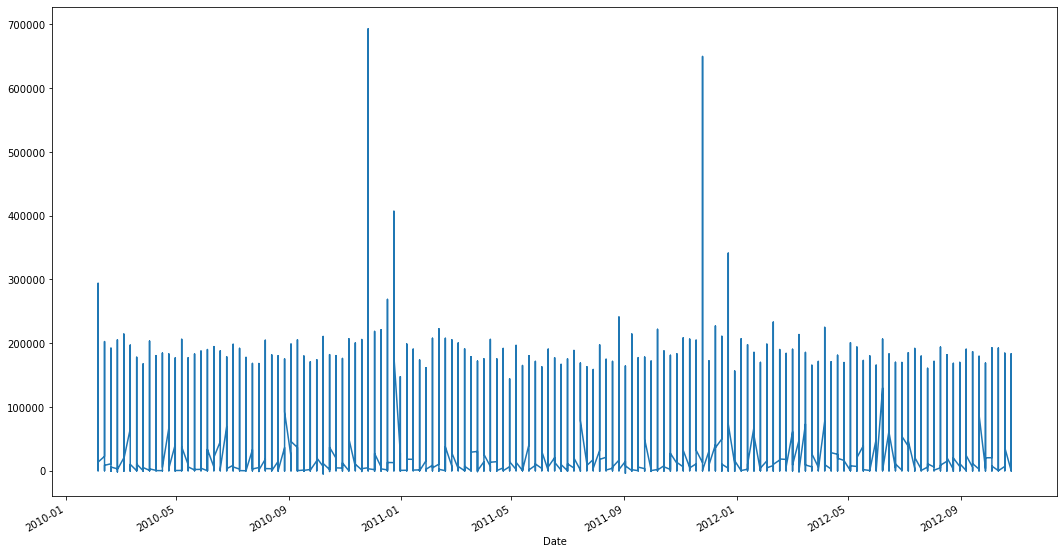

In [9]:
plt.figure(figsize=(18,10))
y.plot()

We can notice from our plot of y, that y has lot of overlapping data. It represents overall Weekly Sales(per department, per store, per week etc). So let's group it by date, and predict the Total Sales for the retail chain (regardless of department or store).

In [10]:
retail_data = retail_data.groupby('Date').sum()

In [11]:
retail_data.head()

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


In [12]:
#let's define our dependent variable y
y= retail_data.Weekly_Sales

<AxesSubplot:xlabel='Date'>

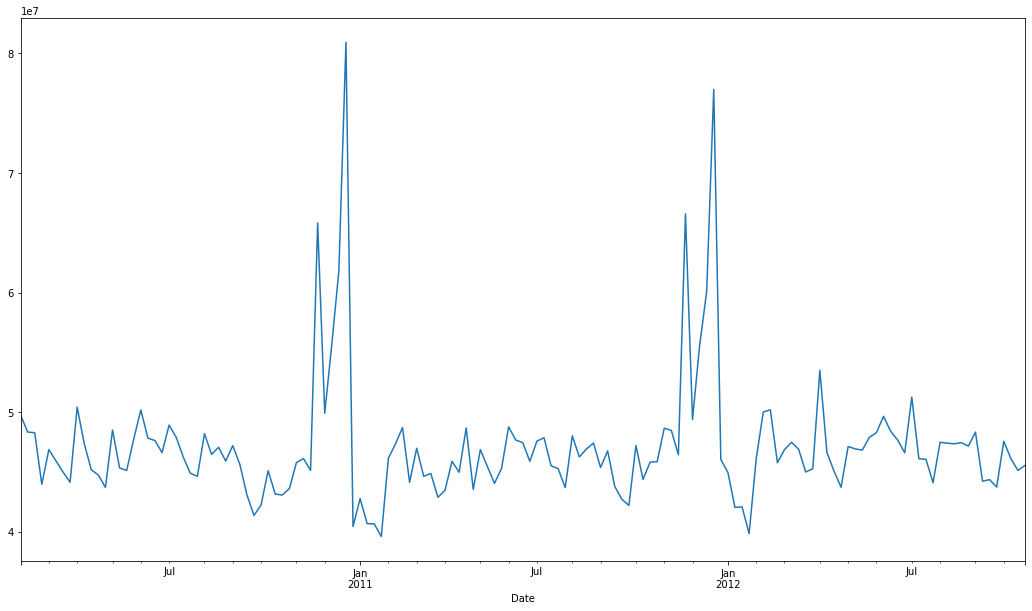

In [13]:
#Let's try visualizing our data using a simple matplotlib.
plt.figure(figsize=(18,10))
y.plot()

#### Decomposition

Our graph looks pretty clean now. No overlapping data. Our plot also shows seasonality. An important feature to be analyzed in a Time Series is the seasonality. 
We have to now decompose the data to see it's Trend, Level and Noise.
Level: is the average value in the series.
Trend: is the increasing or decreasing value in the series.
Seasonality: is the repeating the short-term cycle in the series.
Noise: is the random variation in the series.

In [14]:
#resample the data (per month)
y = retail_data['Weekly_Sales'].resample('M').sum()

We can use the decompose() function to quantify the component parts described above in our data.

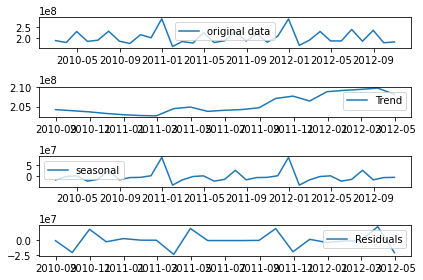

In [15]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition= seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)       #means 4*1 grid 1st subplot
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)         # this means 4*1 grid 2nd subplot
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [16]:
#import statsmodels.api as sm
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#decomposition.plot()

It looks like our data is additive in nature. Now let's test for it's stationarity.

#### Testing for Stationarity

There are many ways to test for stationarity, but one of the most common is the KPSS and Dickey Fuller test. 
Null hypothesis of KPSS test:the time series data in question is stationary
Alternate hypothesis : the time series is not stationary. 
if the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

Augmented Dickey Fuller Test- 
Null Hypothesis: The series is not stationary
Alternate Hypothesis: The series is stationary
if p-value is less than 0.05 we reject the null hypothesis and accept the alternate hypothesis that data is stationary.

In [17]:
from statsmodels.tsa.stattools import kpss
kpss(y,nlags="auto") 

(0.5000000000000054,
 0.04166666666666544,
 32,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is 0.04 which means test failed, series is not stationary

In [18]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                -6.164474e+00
p-value                        7.044294e-08
#Lags Used                     1.000000e+00
Number of Observations Used    3.100000e+01
Critical Value (1%)           -3.661429e+00
Critical Value (5%)           -2.960525e+00
Critical Value (10%)          -2.619319e+00
dtype: float64


Again inDickey Fuller test, it's reverse, here p-value is 0.07 not less than 0.05 which means we accept the null hypothesis that our data is not stationary.

##### Making Data Stationary

Our data needs a constant mean, and a constant variance to be considered stationary.

<AxesSubplot:xlabel='Date'>

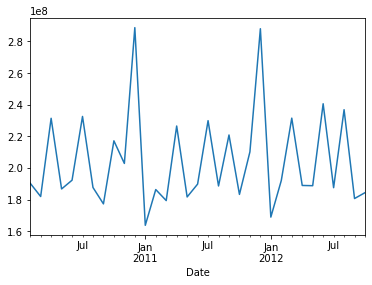

In [19]:
y.plot()

One often used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

In [20]:
#Declare a variable called y_log
y_log = np.log(y)

<AxesSubplot:xlabel='Date'>

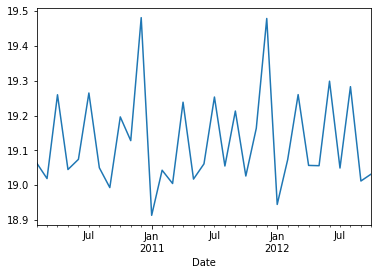

In [21]:
y_log.plot()   # No difference here 

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [22]:
y_log_diff= y_log.diff()

In [23]:
y_log_diff

Date
2010-02-28         NaN
2010-03-31   -0.045209
2010-04-30    0.240635
2010-05-31   -0.214640
2010-06-30    0.029215
2010-07-31    0.190458
2010-08-31   -0.214709
2010-09-30   -0.056864
2010-10-31    0.202981
2010-11-30   -0.068159
2010-12-31    0.353114
2011-01-31   -0.567538
2011-02-28    0.129467
2011-03-31   -0.038151
2011-04-30    0.233487
2011-05-31   -0.220790
2011-06-30    0.043759
2011-07-31    0.191863
2011-08-31   -0.198069
2011-09-30    0.157849
2011-10-31   -0.186561
2011-11-30    0.136967
2011-12-31    0.315351
2012-01-31   -0.533958
2012-02-29    0.128552
2012-03-31    0.186795
2012-04-30   -0.203293
2012-05-31   -0.000818
2012-06-30    0.242668
2012-07-31   -0.249349
2012-08-31    0.233601
2012-09-30   -0.270893
2012-10-31    0.020363
Freq: M, Name: Weekly_Sales, dtype: float64

In [24]:
#Drop all NaN values 
y_log_diff.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

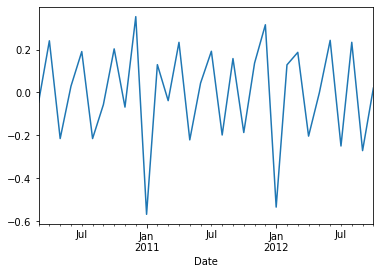

In [25]:
y_log_diff.plot()

#### Test if stationary

In [26]:
kpss(y_log_diff, nlags="auto")

/Users/jisasv1/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.25701415651237874,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary. Note , the second value here is p-value.

#### The ARIMA Model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

In [27]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [28]:
#model = ARIMA(y_log, order=(2, 1, 2))  
#results_ARIMA = model.fit(disp=-1)  
#plt.plot(y_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-y_log_diff)**2))

In [29]:
#Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

##### Make a function to find the MSE of a single ARIMA model

Note: A nonseasonal ARIMA modal is represented as ARIMA(p,d,q), where p is the number of autoregressive terms(AR), d is the number of nonseasonal differences needed for stationarity, and q is the number of lagged forecast errors in the prediction equation(MA).

In [30]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None                 #p,d,q ?
    # Iterate through p_values      
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [31]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [32]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.043
ARIMA(0, 0, 1) MSE=0.016
ARIMA(0, 0, 2) MSE=0.010
ARIMA(0, 1, 0) MSE=0.158
ARIMA(0, 1, 1) MSE=0.045
ARIMA(0, 1, 2) MSE=0.016
ARIMA(0, 2, 0) MSE=0.542
ARIMA(0, 2, 1) MSE=0.169
ARIMA(1, 0, 0) MSE=0.021
ARIMA(1, 1, 0) MSE=0.065
ARIMA(1, 2, 0) MSE=0.286
ARIMA(2, 0, 0) MSE=0.015
ARIMA(2, 0, 1) MSE=0.012
ARIMA(2, 1, 0) MSE=0.029
ARIMA(2, 2, 0) MSE=0.100
Best ARIMA(0, 0, 2) MSE=0.010


Build a model based on the best p,d,q values.

In [33]:
p=0
d=0
q=2
#y_log_diff = y_log.diff().dropna()
model = ARIMA(y_log_diff, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(12)

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                   32
Model:                     ARMA(0, 2)   Log Likelihood                  20.770
Method:                       css-mle   S.D. of innovations              0.105
Date:                Sun, 09 May 2021   AIC                            -33.541
Time:                        00:06:39   BIC                            -27.678
Sample:                    03-31-2010   HQIC                           -31.597
                         - 10-31-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0012      0.000      2.670      0.008       0.000       0.002
ma.L1.Weekly_Sales    -2.0000      0.303     -6.593      0.000      -2.594      -1.405
ma.L2.Weekly_Sales     1.0000      0.301      3.318      0.001       0.409       1.591
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0009j            1.0000           -0.0001
MA.2            1.0000           +0.0009j            1.0000            0.0001
-----------------------------------------------------------------------------
"""

In [35]:
#plt.figure(figsize=(15,10)) #change the size of the figure
#plt.plot(y_log) #original data  #y_log or y_log.diff()??
#plt.plot(model_fit.predict(), color = 'red') #predicted model

#### Visualizing the results

Visualize the original dataset plotted against our model.

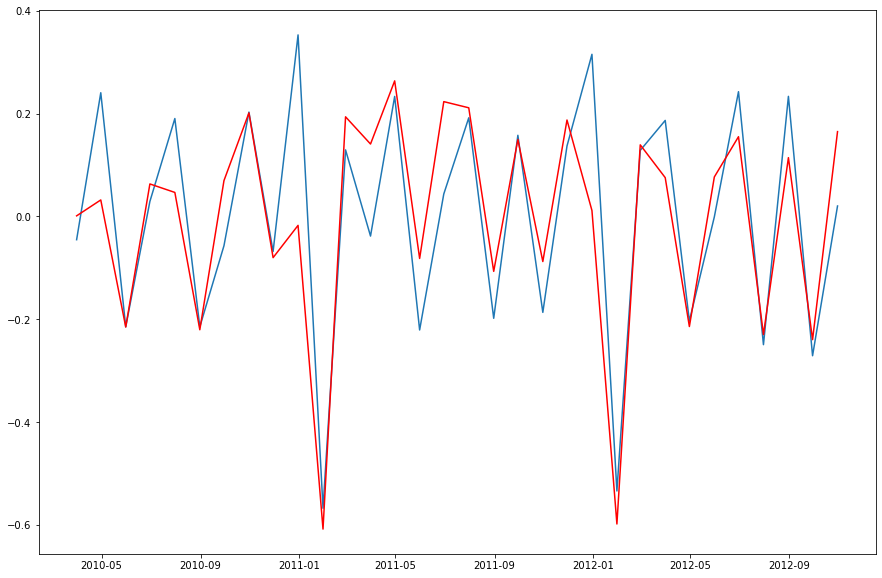

In [36]:
plt.figure(figsize=(15,10)) #change the size of the figure
plt.plot(y_log_diff)#original data  #y_log or y_log_diff()
plt.plot(model_fit.predict(), color = 'red') #predicted model

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

#### Application: Forecasting

We will forecast sales for the next 1 year. 

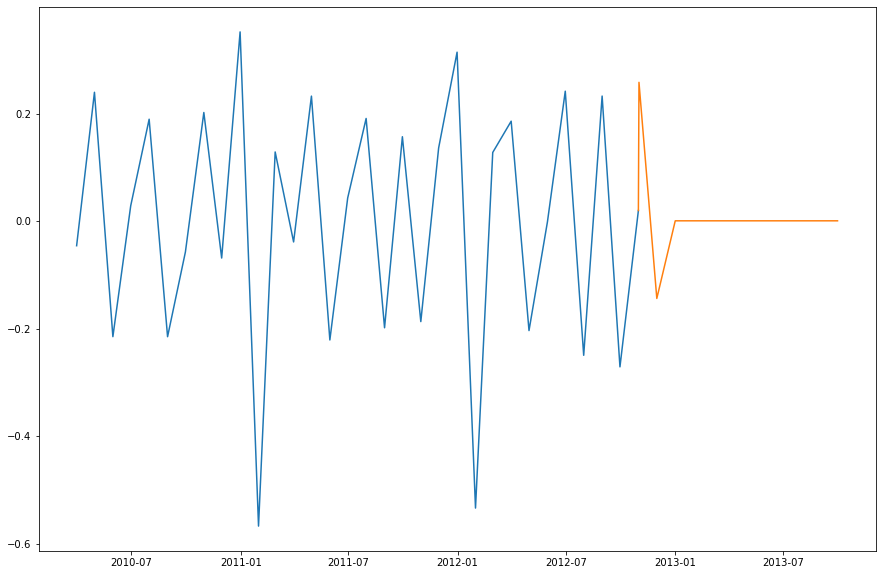

In [37]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12  #Forecast for next 1 year = 12 months (Should be same integer as in model_fit_predict)
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist() #The strftime() function is used to convert date and time 
                                                         #objects to their string representation.
#Refer: https://pandas.pydata.org/docs/reference/api/pandas.date_range.html

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])
future_months.set_index('Date', inplace = True) 
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_log_diff)
plt.plot(y_log_diff['Oct 2012'].append(future_months['Prediction']))
plt.show()

#### Evaluating and Concluding

Our model has made quite good predictions. Sales seem to increase during November and December of every year,perhaps due to holidays,and it kind of remains average during other times of the year.

Remarkably, our ARIMA model made predictions using just one variable.However some sudden circumstances are not handled well by ARIMA.

We could suggest to that doing a regression analysis in addition to the time series one would give a clearer picture. However, we will stop our analysis here, on this note. 